In [1]:
from keras import layers
from keras import models

Using TensorFlow backend.


In [2]:
# to avoid a cuBLAS error, per https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# MNIST using a convolutional neural network

For comparison, a simple linear classifer (using only a few Dense layers, if I remember correctly) topped out at around 97% accuracy. Not bad, but the also simple convnet below gives us 99.3% accuracy. Both train in a similar and relatively short amount of time - the network below does five epochs of 60K inputs/digits in about 25s. 

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [7]:
from keras.datasets import mnist
from keras.utils import to_categorical
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000, 10), (10000, 10))

In [8]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64, verbose=True)

Epoch 1/5
60000/60000 [==============================] - 6s 98us/step - loss: 0.1739 - accuracy: 0.9461
Epoch 2/5
60000/60000 [==============================] - 5s 81us/step - loss: 0.0470 - accuracy: 0.9854
Epoch 3/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.0329 - accuracy: 0.9901
Epoch 4/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.0255 - accuracy: 0.9924
Epoch 5/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.0196 - accuracy: 0.9939


In [9]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
test_loss, test_accuracy

10000/10000 [==============================] - 1s 72us/step


(0.027074831167704268, 0.9912999868392944)

# More complicated (but not that complicated) images - starting with a simple model (no augmentation, etc.)

First, move the data - images - into separate directories for train, validation, and test.

In [3]:
import os, shutil

In [4]:
os.getcwd()

'D:\\work\\github\\DeepLearningWithPython'

In [5]:
original_dataset_dir = 'dogsandcats_source'
base_dir = 'dogsandcats_small'
os.makedirs(base_dir, exist_ok=True)

# ugh, lots of duplication - i'm just using the code in the book, and I won't bother fixing it
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True)

test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

In [6]:
need_to_copy_files = False

train_size = 1000
validation_size = 500
test_size = 500

if need_to_copy_files:
    # ugh, even more duplication
    fnames = ['cat.{}.jpg'.format(i) for i in range(train_size)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(train_cats_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['cat.{}.jpg'.format(i) for i in range(train_size, train_size + validation_size)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(validation_cats_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['cat.{}.jpg'.format(i) for i in range(train_size + validation_size, train_size + validation_size + test_size)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(test_cats_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['dog.{}.jpg'.format(i) for i in range(train_size)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(train_dogs_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['dog.{}.jpg'.format(i) for i in range(train_size, train_size + validation_size)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(validation_dogs_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['dog.{}.jpg'.format(i) for i in range(train_size + validation_size, train_size + validation_size + test_size)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(test_dogs_dir, fname)
        shutil.copyfile(src, dst)

And build the model.

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [21]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['acc'])

And pre-process the data - decode jpeg to RGB, convert to floating point tensors, rescale 0-255 to 0-1. 

In [22]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150, 150), 
                                                    batch_size=20, 
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


And then run and save the model.

Interesting to me that the first time I ran this, the first epoch took 20s and each subsequent epoch took ~5s (except for the last two epochs, which took 15s and 10s, for some reason - in later runs I also got every once in a while a long-running epoch, at different points - not sure why) - perhaps caching, somewhere or in multiple places? When I ran it a second time, the first epoch took the same 5s, so it's likely using whatever cache was set up before. It's also the case that the cache appears to be below the process level, at least - if I restarted Jupyter, the first run was still fast. But restarting the machine made it 20+s again. I watched Task Manager while it was happening and as expected the disk and GPU copy operations were in use. Running it again, hot, and the initial time where the GPU does some data/copy stuff appears to not be there. I could also see the 'dedicated GPU memory usage' graph down below go from about 2GB to 3.5GB (on my old 970 with, it appears, 4GB of RAM).

Also interesting is that if you just re-run the line below - just the fit_generator call - then it appears to pick up (perhaps?) where it left off? At least there's no initial few epochs w/ a lot of learning like normal. Instead, it starts off as good as it was at the end before and finishes off just where it started. If I recreate the model object by running the code above again, then it starts off bad and improves, as I see the first time, and as expected.

In [23]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, 
                              validation_data=validation_generator, validation_steps=50)

model.save('dogsandcats_small_1.h5')

Epoch 1/30
100/100 [==============================] - 5s 55ms/step - loss: 0.6870 - acc: 0.5360 - val_loss: 0.8047 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 6s 58ms/step - loss: 0.6557 - acc: 0.6130 - val_loss: 0.4993 - val_acc: 0.6340
Epoch 3/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6150 - acc: 0.6555 - val_loss: 0.6154 - val_acc: 0.6360
Epoch 4/30
100/100 [==============================] - 5s 48ms/step - loss: 0.5758 - acc: 0.6910 - val_loss: 0.5803 - val_acc: 0.6540
Epoch 5/30
100/100 [==============================] - 5s 48ms/step - loss: 0.5407 - acc: 0.7230 - val_loss: 0.4954 - val_acc: 0.6910
Epoch 6/30
100/100 [==============================] - 5s 48ms/step - loss: 0.5143 - acc: 0.7465 - val_loss: 0.6705 - val_acc: 0.6830
Epoch 7/30
100/100 [==============================] - 5s 48ms/step - loss: 0.4860 - acc: 0.7615 - val_loss: 0.5124 - val_acc: 0.7110
Epoch 8/30
100/100 [==============================] - 5s 48ms/step - 

In [24]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

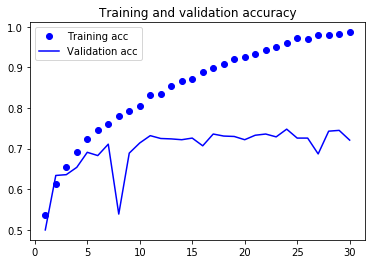

In [25]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

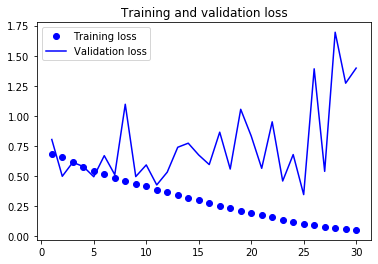

In [26]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()